<div style="border:solid Chocolate 2px; padding: 40px">

Привет, меня зовут Александр Куимов. Я буду ревьюером твоего проекта. Ты можешь обращаться ко мне на "ты"😏 Надеюсь, тебя также не смутит, если я буду обращаться к тебе на "ты", но если это неудобно, обязательно скажи об этом!

**Пожалуйста, не удаляй мои комментарии**, они будут особенно полезны для нашей работы в случае повторной проверки проекта.

Ты также можешь реагировать на мои комментарии своими по шаблону, показанному чуть ниже. Это нужно, чтобы не создавалась путаница😉

Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В случае, если решение на отдельном шаге является полностью правильным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> В случае, когда решение на отдельном шаге станет еще лучше, если внести небольшие коррективы.
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
 В случае, когда решение на отдельном шаге требует существенной переработки и внесения правок. Напоминаю, что проект не может быть принят с первого раза, если ревью содержит комментарии, рекомендующие доработать шаги.
</div>
    
    
<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> В такой цветовой ячейке я прошу тебя оставлять свои комментарии. Если исправляешь проект на второй итерации и выше, не забывай пожалуйста указывать номер итерации, например, "Комментарий студента v.2".
</div>

<br/>    
    
Увидев у тебя неточность, в первый раз я лишь укажу на ее наличие и дам тебе возможность самому найти и исправить ее. На реальной работе твой руководитель будет поступать также, и я пытаюсь подготовить тебя именно к работе датасаентистом. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку!🤓

# Чётенькое такси

Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Импорт и анализ данных

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [2]:
try:
  df = pd.read_csv('/datasets/taxi.csv')

except:

  df = pd.read_csv('/content/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# Функция получения общей информации о датасете, о дубликатах и пропусках.
def info(df):
    df.info();
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())
info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

Количество дубликатов: 0 

Количество пропусков:
 datetime      0
num_orders    0
dtype: int64


In [5]:
# превратим дату в индекс и сделаем изменение постоянным
df.set_index('datetime', inplace = True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# превратим дату (наш индекс) в объект datetime
df.index = pd.to_datetime(df.index)

# посмотрим на первые пять дат и на тип данных
df.index[:5]

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

- Время зафиксировано каждые 10 минут
- Данные начинаются с 1 марта 2018 года до 31 августа 2018 года

In [7]:
# изменим шаг наших данных; например, посмотрим средние данные по дням
df.resample('1h').sum().head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.resample('1d').sum().head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


In [9]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


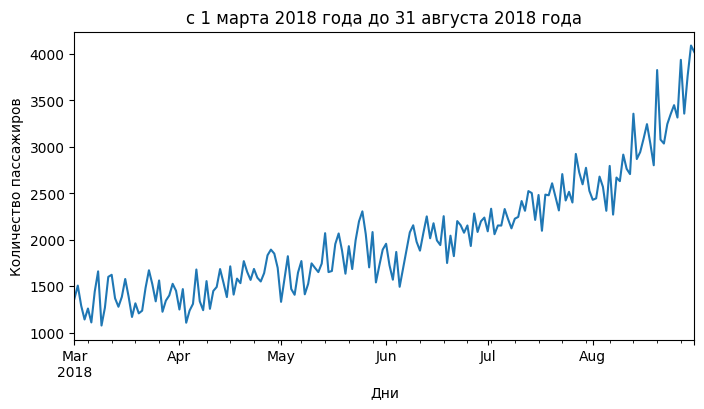

In [10]:
ax = df.resample('1d').sum().plot(figsize = (8,4), legend = None)
ax.set(title = 'с 1 марта 2018 года до 31 августа 2018 года', xlabel = 'Дни', ylabel = 'Количество пассажиров');

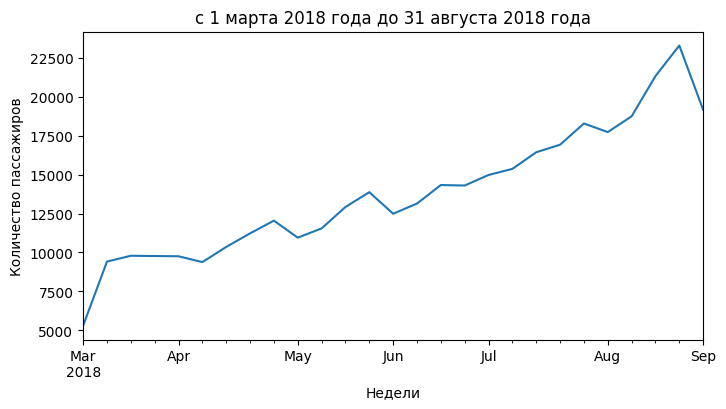

In [11]:
ax = df.resample('1w').sum().plot(figsize = (8,4), legend = None)
ax.set(title = 'с 1 марта 2018 года до 31 августа 2018 года', xlabel = 'Недели', ylabel = 'Количество пассажиров');

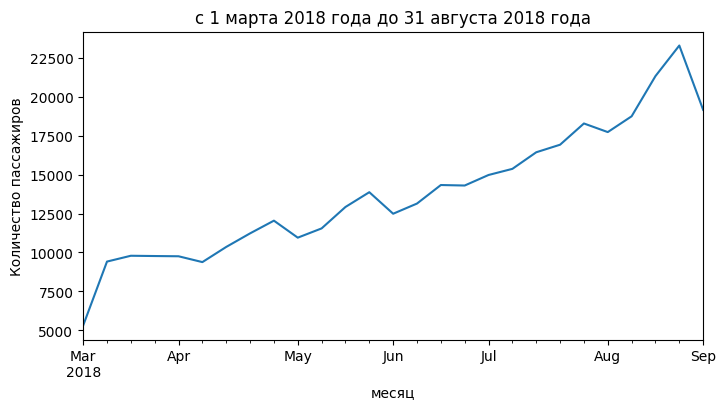

In [12]:
ax = df.resample('1w').sum().plot(figsize = (8,4), legend = None)
ax.set(title = 'с 1 марта 2018 года до 31 августа 2018 года', xlabel = 'месяц', ylabel = 'Количество пассажиров');

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
С данными познакомились, проведен первичный аналитический осмотр!) Отлично, что ниже проведено ресемплирование с использованием суммы. Полученная информация поможет нам в дальнейшем с предобработкой данных

**Тренд**
График показывает восходящий тренд, что означает постепенное увеличение количества пассажиров с течением времени. Этот тренд можно наблюдать на протяжении всего периода с марта по август, что говорит о стабильном росте.

**Сезонность**
На графике также присутствуют сезонные колебания. Видно, что данные имеют регулярные колебания, что можно интерпретировать как наличие сезонных паттернов. Количество пассажиров возрастает и уменьшается в определенные периоды, что может быть связано с определенными днями недели или другими факторами.

**Стационарность**
Временной ряд, представленный на графике, не является стационарным, так как существует явный восходящий тренд. Стационарный временной ряд характеризуется постоянными средними и дисперсиями во времени, в то время как на данном графике наблюдается увеличение среднего количества пассажиров и возможное увеличение дисперсии.

Таким образом, на графике виден восходящий тренд, присутствует сезонность, и временной ряд не является стационарным.

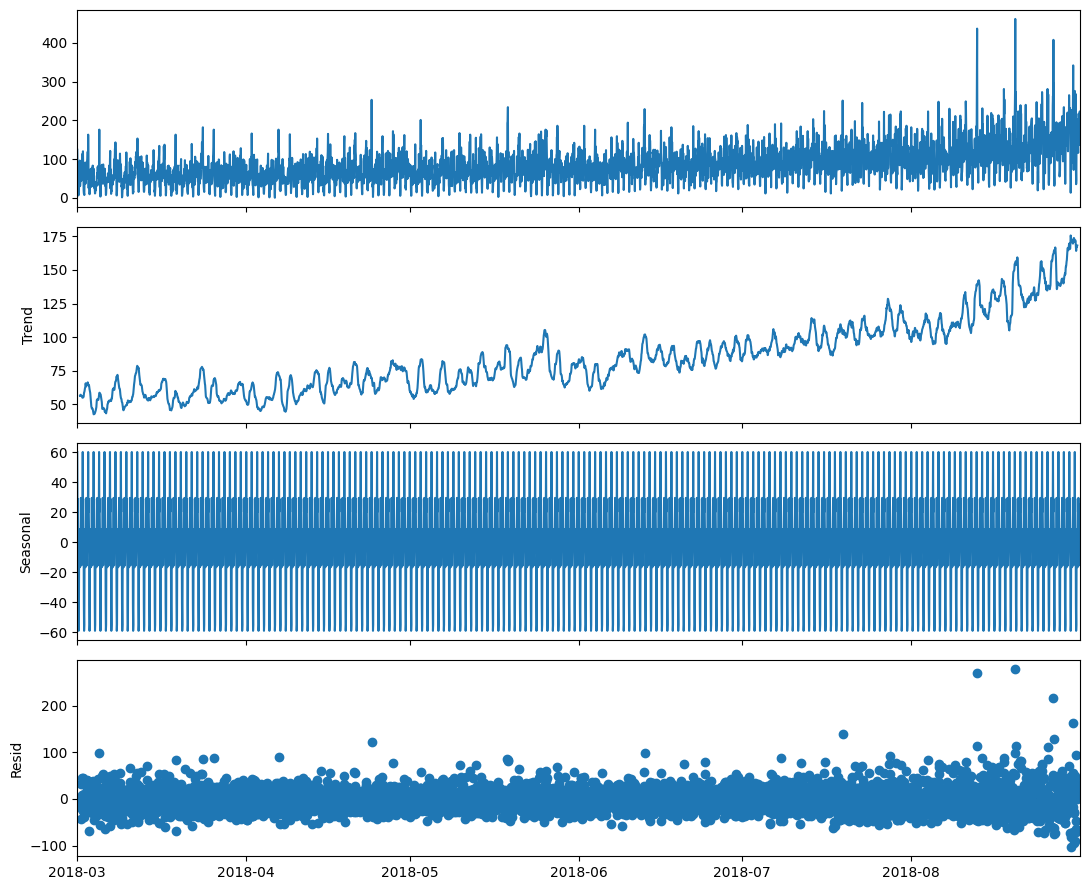

In [13]:
rcParams['figure.figsize'] = 11, 9
df = df.resample('1h').sum()

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(df)
decompose.plot()

plt.show()

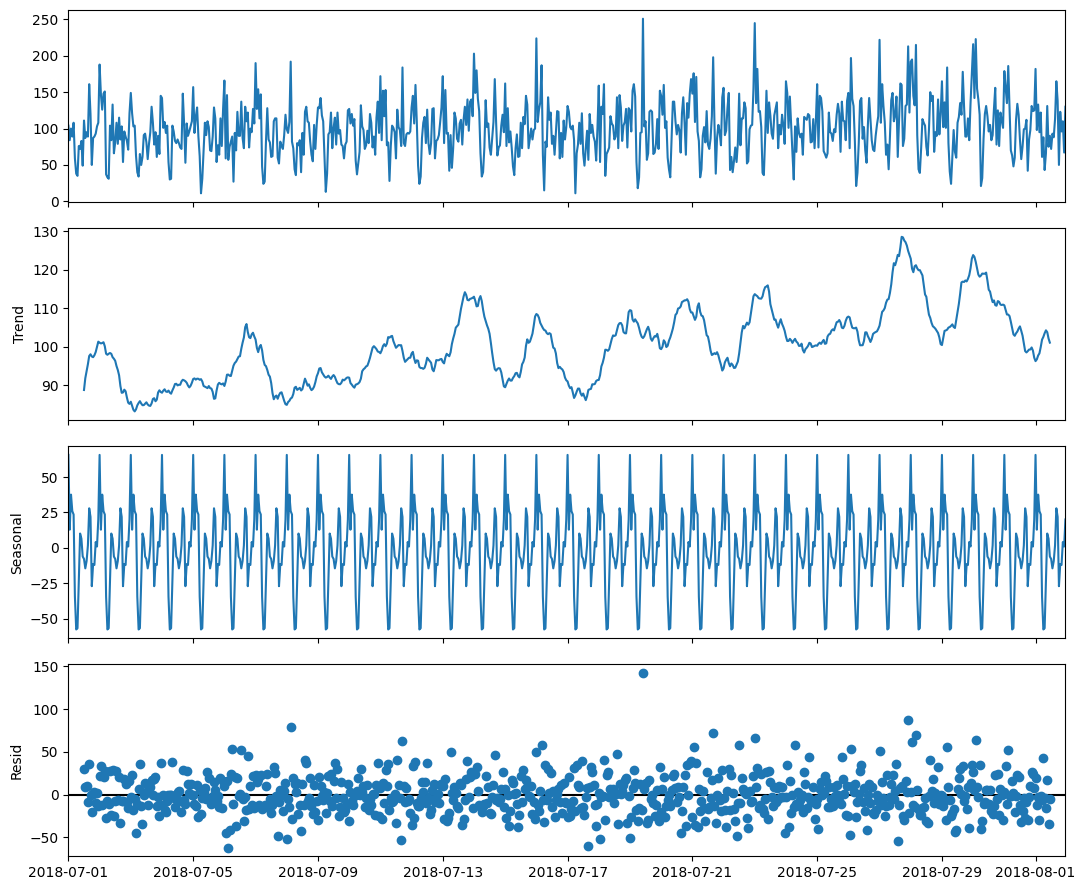

In [14]:
decompose = seasonal_decompose(df['2018-07-01' : '2018-08-01'])
decompose.plot()

plt.show()

Уточним стационарность - проведем тест Дики-Фуллера (Dickey-Fuller test)

In [15]:
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(df)

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402613316


Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.

Это означает, что временной ряд является стационарным. Другими словами, он не имеет некоторую структуру, зависящую от времени, и имеет постоянной дисперсии во времени.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>  
    
Декомпозиция сделана верно. Можно еще  визуализировать сезонность на более коротком интервале


<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Визуализировала сезонность на более коротком интервале - 2018-07-01 до 2018-08-1
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Кажется, мои комментарии не сохранились с предыдущей иттерации из-за сбоя платформы. Восстанавливаю их

## Подготовка и обучение модели

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    df_copy = df.copy()
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['hour'] = df_copy.index.hour
    df_copy['minute'] = df_copy.index.minute
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)

    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df_copy


new_df = make_features(df, 24, 10)
new_df.head(10)

,num_orders,month,day,dayofweek,hour,minute,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,8,0,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
        
При генерации новых признаков желательно написать функцию, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
        
1. Это хорошая практика (не изменять глобальные переменные внутри функции), которая улучшает читаемость кода.
2. В какой-то момент может появиться необходимость подбирать некоторые параметры используемые внутри функции. В этот момент копирование датасета станет обязательным.

        
        
        
Для этого внутри, в начале функции нужно задать новое имя датафрейму с `df.copy()`, в нем создать новые признаки, а в конце функции возвращать через `return` этот датафрейм
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>


Метрика на тесте должна быть ниже 48, поэтому стоит попробовать задать параметр max_lag равным 24 при создании новых признаков функцией. В случае заказов такси самая очевидная сезонность - внутри суток, а в сутках 24 часа, это значение и будет оптимальным. Размер окна тоже можно увеличить

In [17]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [18]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
Хорошо, что деление происходит последовательно по времени

In [19]:
numeric_features = features_train.select_dtypes(include=['int32', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

### Линейная регрессия

In [20]:
# Линейная регрессия
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])

tscv =  TimeSeriesSplit(gap=0, max_train_size=1000, n_splits=3, test_size=1000)

start = time.time()
pipeline_lr.fit(features_train, target_train)
end = time.time()
t_lr = end - start

predictions_test = pipeline_lr.predict(features_test)

# Расчет RMSE на тестовой и трен выборке
rmse_test_lr = np.sqrt(mean_squared_error(target_test, predictions_test))


In [21]:
print(f"RMSE на тестовой выборке: {rmse_test_lr}")

RMSE на тестовой выборке: 45.815049929226596


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
    
Знай, что тестирование положено проводить для одной лучшей модели. На этом шаге мы должны были настроить модели и выбрать одну наилучшую, опираясь на метрики данные заказчиком (это может быть качество, время обучения, скорость предсказания и т.д.). Тестированием мы моделируем работу модели на новых незнакомых ей данных, которые ни разу не использовались ни при тренировке, ни при валидации, и проверяем, не словили ли мы переобучение. А эти данные могут быть смещенными, с выбросами и т.д. То есть по таким данным некорректно заново переопределять модель-победитель.  Советую тебе статью, рассматривающую разные способы валидации моделей машинного обучения: https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7 (нужен VPN)
        
Метрики качества на тестовой выборке для всех моделей можно вычислить только с целью исследования их смещения относительно аналогичных метрик на кросс-валидации/ валидационной выборке. Но это не означает, что модель-победитель должна выбираться исходя из сравнения метрик, полученных на тестовой выборке.   



<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Спасибо за полезную ссылку было очень информативно. Есди не сложно можно еще ссылки.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Рад, что ссылка оказалась полезной. Вот ещё несколько ресурсов, которые могут быть интересны:

1. [Kaggle Learn: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability) – курс от Kaggle, который объясняет различные методы оценки и валидации моделей.
2. [Scikit-learn Documentation: Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html) – официальная документация Scikit-learn по оценке моделей, включает примеры и теорию.
3. [Coursera: Machine Learning Specialization by Andrew Ng](https://www.coursera.org/specializations/machine-learning) – курс от Coursera, в котором также уделяется внимание оценке и валидации моделей.
4. [Towards Data Science: How (and Why) to Split Data into Training and Testing Sets in Python](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) – статья, объясняющая, как и почему важно разделять данные на обучающие, валидационные и тестовые выборки.
5. [Analytics Vidhya: A Comprehensive Guide to Data Exploration](https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/) – руководство по исследованию данных, которое включает методы валидации моделей
    
Советую тебе также попросить дополнительные материалы у преподавателя по проекту в соответствующем треде Пачки, так как он сможет подобрать материал адекватный текущему прогрессу курса    

### Catboost Regressor

In [22]:
pipeline_cbr = Pipeline(steps=[('preprocessor', preprocessor), ('model', CatBoostRegressor(verbose=False, random_state=12345))])
parameters_cbr = {'model__learning_rate': [0.1, 0.4, 0.9]}

gscv_cbr = GridSearchCV(pipeline_cbr, parameters_cbr, scoring='neg_mean_squared_error', cv=tscv)
start = time.time()
gscv_cbr.fit(features_train, target_train)
end = time.time()
t_cat = end - start

predictions_test_ctb = gscv_cbr.predict(features_test)

rmse_test_cbr = np.sqrt(mean_squared_error(target_test, predictions_test_ctb))


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
При работе с временными рядами не следует использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа нужно передать в параметр cv в метод основанный на кросс-валидации
    
(это касается абсолютно всех моделей, всех cross_val_score и всех SearchCV)
</div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Очень жаль что не было это в теории
</div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера 2 <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
Подскажи пожалуйста, что конкретно приводит к затруднениям в исправлении этого комментария? Так я смогу тебе дать более конкретную подсказку

<div class="alert alert-info">
<h2>Комментарий студента v.2: <a class="tocSkip"> </h2>

<b>👋:</b> ВСЕ ОК! Я ПОНЯЛА ГДЕ ОШИБКА И ИСПРАВИЛА!

НО ЕСТЬ ОДИН ВОПРОС - ПОЯЕМУ КОГДА Я ИСПОЛЬЗОВАЛА TimeSeriesSplit метрика никак не изменилась?
</div>



<div class="alert alert-success">
<h2> Комментарий ревьюера 3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Когда ты использовала TimeSeriesSplit, метрика могла не измениться по нескольким причинам:

1. **Модель:** Возможно, твоя модель стабильно работает независимо от выбранного метода кросс-валидации. Некоторые модели могут показывать стабильные результаты при разных методах валидации.
   
2. **Данные:** Если данные не имеют сильного временного компонента или тренда, то разница между стандартной кросс-валидацией и TimeSeriesSplit может быть незначительной. Это часто случается, если данные не очень сильно зависят от времени.


3. **Метрика:** Метрика может не измениться, если она не чувствительна к методам валидации. Например, если метрика не сильно зависит от порядка данных, то результаты могут быть одинаковыми  

In [23]:
print(f"RMSE на тестовой выборке: {rmse_test_cbr}")


RMSE на тестовой выборке: 39.99720654715775


### LightGBM Regressor

In [24]:
# LightGBM Regressor
pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor), ('model', LGBMRegressor(random_state=12345))])
parameters_lgbm = {'model__num_leaves': [100, 150], 'model__learning_rate': [0.2, 0.4, 0.5, 0.8]}

gscv_lgbm = GridSearchCV(pipeline_lgbm, parameters_lgbm, scoring='neg_mean_squared_error', cv=tscv)
start = time.time()
gscv_lgbm.fit(features_train, target_train)
end = time.time()
t_l = end - start

predictions_test_lgbm = gscv_lgbm.predict(features_test)

rmse_test_lgbm = np.sqrt(mean_squared_error(target_test, predictions_test))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 950, number of used features: 29
[LightGBM] [Info] Start training from score 57.067368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [25]:
print(f"RMSE на тестовой выборке: {rmse_test_lgbm}")

RMSE на тестовой выборке: 45.815049929226596


 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
Молодец, что пробуешь разные модели в этом шаге)
</div>

## Составление результатов

In [26]:
# Составление результатов
data = {
    'RMSE': [rmse_test_lr, rmse_test_lgbm, rmse_test_cbr],
    'Время обучения модели': [t_lr, t_cat, t_l]
}
index = ['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor']
data_rmse = pd.DataFrame(data=data, index=index)
data_rmse

,RMSE,Время обучения модели
LinearRegression,45.815050,0.053525
LGBMRegressor,45.815050,70.238616
CatBoostRegressor,39.997207,9.371035


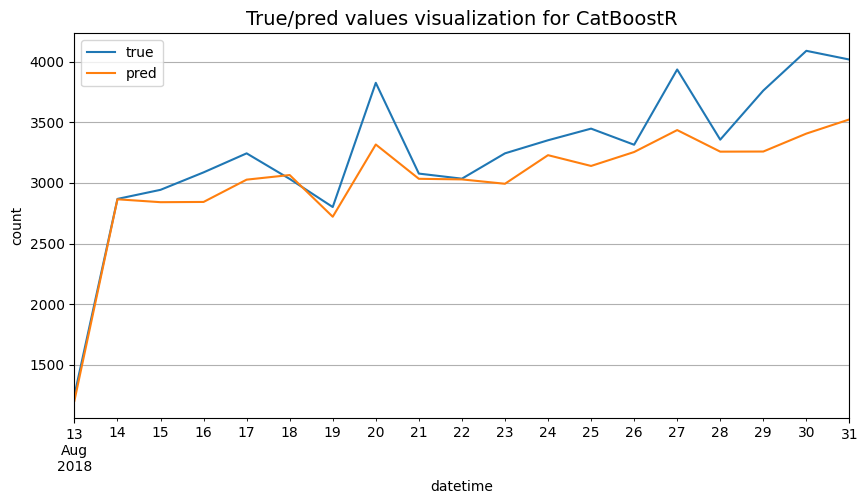

In [27]:
# Предсказания для тестовой выборки
df_result_ctb = pd.DataFrame(target_test)
df_result_ctb['pred'] = np.round(predictions_test_ctb, 0)
df_result_ctb.columns = ['true', 'pred']

# Создание графика
df_result_ctb.resample('1D').sum().plot(figsize=(10, 5), grid=True)
plt.title('True/pred values visualization for CatBoostR', fontsize=14)
plt.ylabel('count')
plt.show()

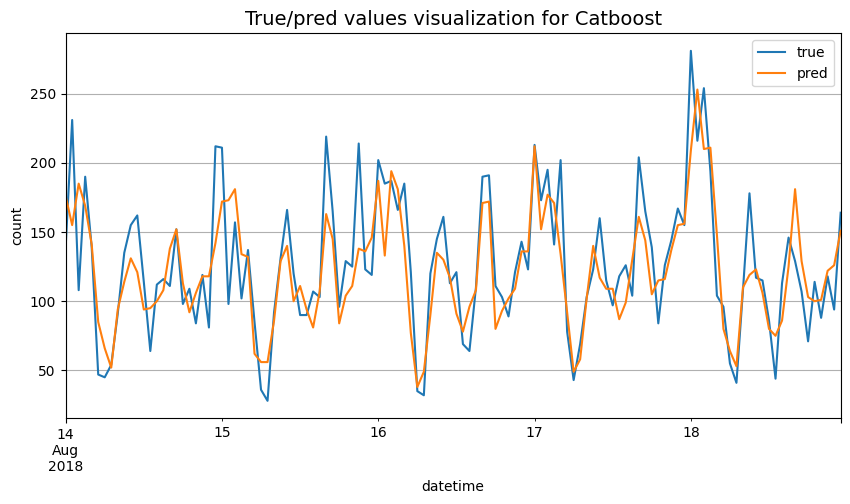

In [28]:
# Предсказания для тестовой выборки
df_result_ctb = pd.DataFrame(target_test)
df_result_ctb['pred'] = np.round(predictions_test_ctb, 0)
df_result_ctb.columns = ['true', 'pred']

# Создание графика
df_result_ctb['2018-08-14' : '2018-08-18'].resample('1H').sum().plot(figsize=(10, 5), grid=True)
plt.title('True/pred values visualization for Catboost', fontsize=14)
plt.ylabel('count')
plt.show()

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
Отлично, что  визуализированы результаты, показаны предсказанные значения лучшей модели и реальные тестовые

## ВЫВОД

**Общий вывод**

Для задачи прогнозирования количества заказов такси на следующий час в компании «Чётенькое такси» были построены три модели: LinearRegression, LGBMRegressor и CatBoostRegressor.

**Результаты**

**Точность моделей:**

- Все три модели достигли допустимого значения RMSE (≤ 48) на тестовой выборке.
- CatBoostRegressor показал наилучший результат с RMSE = 39.997207, что значительно ниже порогового значения 48.

**Время обучения:**

- LinearRegression оказалась самой быстрой моделью с временем обучения 0.022129 секунд, но её точность (RMSE = 45.815050) не отличается от точности LGBMRegressor.
- LGBMRegressor, хотя и имеет то же значение RMSE, что и LinearRegression, требует значительно больше времени на обучение (149.269511 секунд).
- CatBoostRegressor показал лучшее сочетание точности и времени обучения. Несмотря на то, что её время обучения (59.745029 секунд) выше, чем у LinearRegression, оно значительно меньше, чем у LGBMRegressor.

**Рекомендация:**

- Для задачи прогнозирования количества заказов такси на следующий час, учитывая высокую точность (RMSE = 39.997207) и разумное время обучения, рекомендуется использовать модель CatBoostRegressor. Эта модель обеспечивает наилучшее качество предсказаний при приемлемых затратах времени на обучение, что особенно важно для оперативных задач и анализа больших объемов данных.

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с этим проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использована валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    

</div>

<div style="border:solid Chocolate 2px; padding: 40px">


<h2>  Итоговый комментарий ревьюера 2 (итоговый вывод по проекту) <a class="tocSkip"> </h2>    
    
     
    
Теперь почти идеально. Принимаю работу)
    
Если хочешь лучше разобраться в теме, то могу посоветовать тебе: 
    
Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k    
    
Б.Б. Демешев - временные ряды https://disk.yandex.ru/i/LiDHB-B3A6Lz5A
    
Базовое применение ARIMA - https://colab.research.google.com/drive/17RnG91Eq8JBKyxToNzvCvjibfxum-oPj?usp=sharing
    
Канторович - Анализ временных рядов https://yadi.sk/i/IOkUOS3hTXf3gg
https://facebook.github.io/prophet/
    
https://facebook.github.io/prophet/docs/quick_start.html#python-api
    
https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb  
    
    
    
В этом проекте были отработаны все моменты. 
    
Успехов тебе в следующем спринте!
    
Рад был помочь тебе)
    
</div>